In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.8 MB/s eta 0:00:00a 0:00:01


# **Загрузка данных**

In [2]:
!pip install dicom2nifti

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 49.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pydicom
    Found existing installation: pydicom 2.4.4
    Uninstalling pydicom-2.4.4:
      Successfully uninstalled pydicom-2.4.4


In [3]:
!pip install --upgrade pydicom

# **Обработка изображений *.dicom и их визуализация**

In [4]:
import os
import numpy as np
import pydicom
import cv2
from tqdm import tqdm
from skimage.transform import resize

def load_and_process_pair(dcm_path, jpg_path):
    """Загружает и обрабатывает пару DICOM + JPG"""
    ds = pydicom.dcmread(dcm_path)
    img = ds.pixel_array.astype(np.float32)
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        img = img * ds.RescaleSlope + ds.RescaleIntercept

    # Медицински значимая нормализация
    hu_min, hu_max = -1000, 2000  # Стандартный диапазон для КТ
    img = np.clip(img, hu_min, hu_max)
    img_normalized = (img - hu_min) / (hu_max - hu_min)  # [0, 1]
    
    mask = cv2.imread(jpg_path, cv2.IMREAD_GRAYSCALE)
    mask_normalized = mask/255.0
    mask_binary = (mask_normalized > 0.5).astype(np.float32)
    
    # Приведение к одинаковому размеру
    if img_normalized.shape != mask.shape:
        mask = resize(mask, img_normalized.shape, order=0, preserve_range=True, anti_aliasing=False)

    
    return img_normalized, mask_binary

def load_dataset(x_files, y_files, limit=None):
    """Загружает весь датасет"""
    images = []
    masks = []
    
    for i in tqdm(range(min(len(x_files), limit if limit else len(x_files)))):
        img, mask = load_and_process_pair(x_files[i], y_files[i])
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

In [5]:
def path(fname):
    return f'/kaggle/input/train-data/CT/' + fname

def get_data():
    X_path = path('')
    X_filenames = []
    y_filenames = []
    for directory in os.listdir(X_path)[:-1]:
        for dirName, subdirList, fileList in os.walk(X_path+directory):
            for filename in fileList:
                if ".dcm" in filename.lower():
                    X_filenames.append(os.path.join(dirName, filename))
                if ".png" in filename.lower():
                    y_filenames.append(os.path.join(dirName, filename))
    assert len(X_filenames) == len(y_filenames)
    return sorted(X_filenames), sorted(y_filenames)

In [6]:
X_filenames, y_filenames = get_data()

In [7]:
X_data, y_data = load_dataset(X_filenames, y_filenames)

100%|██████████| 2778/2778 [00:41<00:00, 66.19it/s]


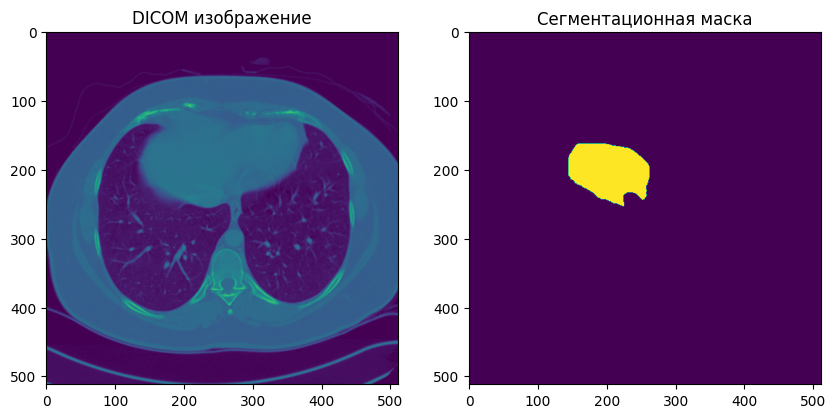

In [8]:
import matplotlib.pyplot as plt

def plot_sample(idx):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(X_data[idx])
    plt.title("DICOM изображение")
    
    plt.subplot(1,2,2)
    plt.imshow(y_data[idx])
    plt.title("Сегментационная маска")
    plt.show()

plot_sample(8)

Посмотрим на минимальные и максимальные значения в изображениях и их меток

In [9]:
print('Image')
print(f'Min value: {np.min(X_data[8])}; Max value: {np.max(X_data[8])}')
print()
print('Label')
print(f'Min value: {np.min(y_data[8])}; Max value: {np.max(y_data[8])}')

Image
Min value: 0.0; Max value: 1.0

Label
Min value: 0.0; Max value: 1.0


# **Обработка с помощью аугментации**

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def preprocessing_data(images, labels):
    # Определение аугментаций для изображений и масок
    data_transforms = A.Compose([
        A.Resize(256, 256),  # Изменение размера до 256x256 пикселей
        A.HorizontalFlip(),  # Горизонтальное отражение
        A.VerticalFlip(),    # Вертикальное отражение
        A.Rotate(limit=30),  # Поворот на случайный угол до ±30 градусов
        ToTensorV2()  # Преобразование в тензор PyTorch
    ])

    # Применение аугментаций к изображению
    
    images_transfromed = list()
    labels_transformed = list()
    
    for im,l in zip(images,labels):
        data_transformed = data_transforms(image=im,mask=l)
        
        im_transformed = data_transformed['image']
        l_transformed = data_transformed['mask']
        
        im_transformed = im_transformed.float()
        l_transformed = l_transformed.unsqueeze(0).float()
        
        images_transfromed.append(im_transformed)
        labels_transformed.append(l_transformed)
        
    
    return images_transfromed, labels_transformed

In [12]:
ims, ls = X_data, y_data

ims_transformed, ls_transformed =  preprocessing_data(ims,ls)

In [13]:
ims_transformed[0].shape

torch.Size([1, 256, 256])

In [14]:
# Визуализация тензоров изображений и их меток
def get_visualization_tensor(image,label):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    axes[0].imshow((image * 255).squeeze(0).numpy().astype('uint8') * 255, cmap='gray')
    axes[0].set_title('Изображение')
    axes[0].axis('off')

    axes[1].imshow(label.squeeze(0), cmap='gray')
    axes[1].set_title('Маска')
    axes[1].axis('off')

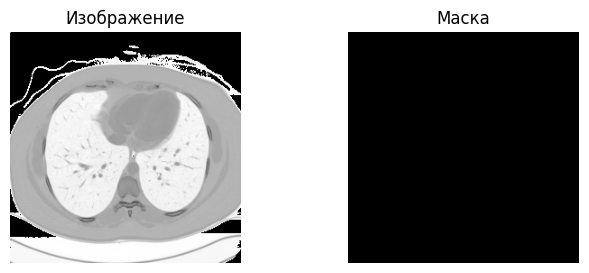

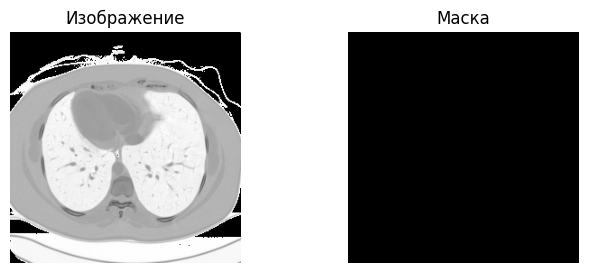

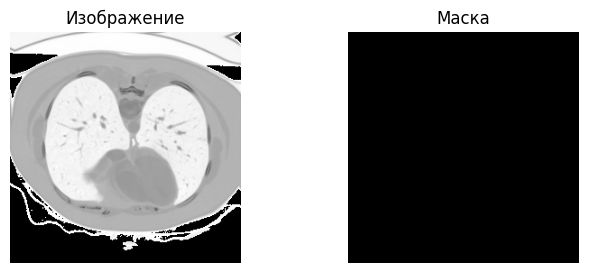

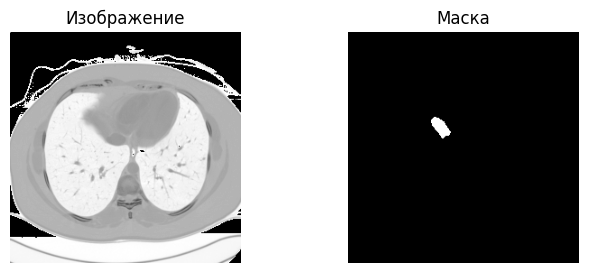

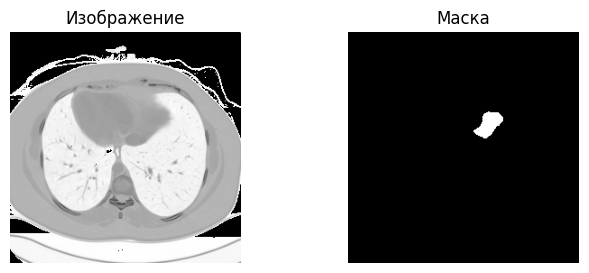

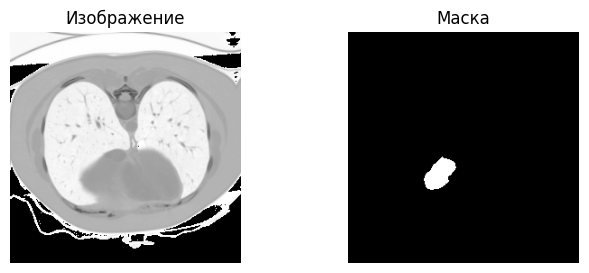

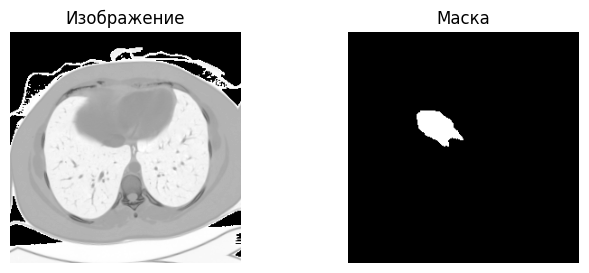

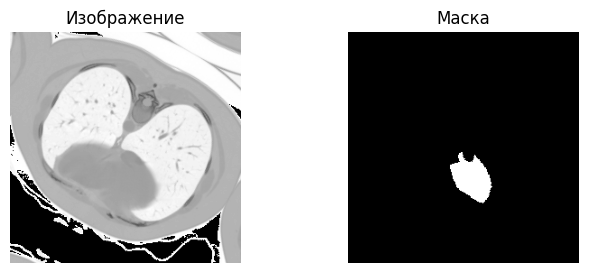

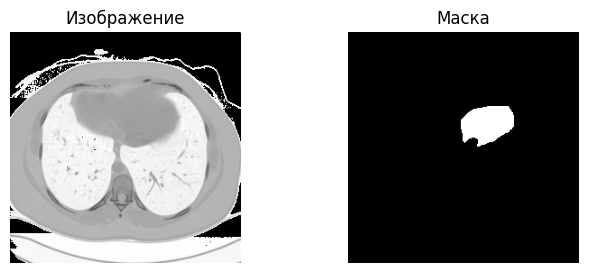

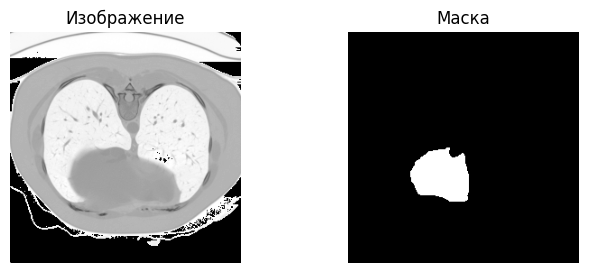

In [15]:
for i ,(im,l) in enumerate(zip(ims_transformed,ls_transformed)):
    if i < 10:
        get_visualization_tensor(im,l)

# **Преобразование данных в датасет**

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Используем Dataset для создания пользовательского датасета CustomDataset, далее обернем его в DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label


custom_dataset = CustomDataset(ims_transformed, ls_transformed)


train_size = int(0.8 * len(custom_dataset))
val_size = int(0.1 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size

generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(custom_dataset, [train_size,val_size,test_size], generator=generator)

batch_size = 8

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)

test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

In [17]:
print(f'Train(тренировочный) объём данных: {len(train_loader)}')
print(f'Val(валидационный) объём данных: {len(val_loader)}')
print(f'Test(тестовый) объём данных: {len(test_loader)}')

Train(тренировочный) объём данных: 277
Val(валидационный) объём данных: 34
Test(тестовый) объём данных: 34


# **Индекс Жакара**

In [18]:
def get_iou(out,labels):
    eps = 1e-8
    out = torch.sigmoid(out) > 0.7
    out = out.squeeze(1)
    labels = labels.squeeze(1)
    intersection = torch.logical_and(out, labels).sum().float()
    union = torch.logical_or(out, labels).sum().float()
    
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

# **Тренировка**

In [19]:
if torch.cuda.is_available():
    print('CUDA доступен. Вычисления будут производиться на GPU.')
else:
    print('CUDA недоступен. Вычисления будут производиться на CPU.')

CUDA доступен. Вычисления будут производиться на GPU.


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Ипользуем коллбэки для сохранения моделей

In [21]:
import torch

class BestModelCheckpointCallback:
    def __init__(self, model, filepath, monitor='iou_val', mode='min'):
        self.model = model
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best_metric = float('inf') if mode == 'min' else float('-inf')

    def __call__(self, metric, name_model):
        if (self.mode == 'min' and metric < self.best_metric) or (self.mode == 'max' and metric > self.best_metric):
            self.best_metric = metric
            torch.save(self.model.state_dict(), self.filepath.format(name_model))
            print(f"Model saved with {self.monitor}: {metric}")

# Определение пути для сохранения наилучшей модели
filepath = 'best_model_{}.pth'

In [22]:
def train(model,train_dl,val_dl,num_epochs, loss_fn, optimizer, name_model, use_scheduler=False, access_key=True):    
    model = model.to(device)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[num_epochs//2, num_epochs//1.4, num_epochs//1.2], gamma=0.2)
    
    history = {'epochs loss train':[],'epochs loss val':[],'iou(Jaccard index) train':[],'iou(Jaccard index) val':[]}
    
    best_model_callback = BestModelCheckpointCallback(model, filepath, monitor='iou_val', mode='max')
    
    for epoch in range(num_epochs):
        epoch_loss_train = 0
        epoch_loss_val = 0
        iou_batches_val = []
        iou_batches_train = []
              
        model.train()
        for batch in train_dl:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
        
            optimizer.zero_grad()
            
            if access_key:
                output = model(images)['out']
            else:
                output = model(images)

            loss_train = loss_fn(output, labels)
            loss_train.backward()
            
            optimizer.step()
            
            epoch_loss_train += loss_train.item()
            
            iou = get_iou(output,labels)
            iou_batches_train.append(iou)
        
        avg_iou_epoch_train = sum(iou_batches_train)/len(iou_batches_train)
        
        if use_scheduler:
            scheduler.step()
        
        model.eval()
                 
        for batch in val_dl:  
            images, labels = batch
            images, labels = images.to(device), labels
            
            with torch.no_grad():
                if access_key:
                    out = model(images)['out'].detach().cpu()
                else:
                    out = model(images).detach().cpu()
                
                loss_val = loss_fn(out, labels)
                epoch_loss_val += loss_val.item()
            
            iou = get_iou(out,labels)
            
            iou_batches_val.append(iou)
        
        avg_iou_epoch_val = sum(iou_batches_val)/len(iou_batches_val)
        
        best_model_callback(avg_iou_epoch_val, name_model)
        
        history['epochs loss train'].append(epoch_loss_train/len(train_dl))
        history['epochs loss val'].append(epoch_loss_val/len(val_dl))
        history['iou(Jaccard index) train'].append(avg_iou_epoch_train)
        history['iou(Jaccard index) val'].append(avg_iou_epoch_val)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('------------')
        print(f'Loss train: {epoch_loss_train/len(train_dl):.4f}')
        print(f'Loss val: {epoch_loss_val/len(val_dl):.4f}')
        print(f'Iou(Jaccard index) train: {avg_iou_epoch_train:.4f}')
        print(f'Iou(Jaccard index) val: {avg_iou_epoch_val:.4f}')
        print('------------')
        
    return history

# **Модель на основе архитектуры U-Net (собственная реализация)**

In [23]:
import torch.nn as nn

moment = 0.1

# Определение блока свертки для пути умешьшения размерности (Convolution Block)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(out_channels, momentum= moment),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(out_channels, momentum= moment),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)
    
# Определение блока свертки для пути увеличения размерности (Convolution Block Up) 
class ConvBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlockUp, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(out_channels, momentum= moment),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels//2, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(out_channels//2, momentum= moment),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)

# Определение U-Net модели
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.enc0 = ConvBlock(in_channels,64)
        self.maxpool0 = nn.MaxPool2d(kernel_size=2)
        
        self.enc1 = ConvBlock(64,128)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.enc2 = ConvBlock(128,256)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3 = ConvBlock(256,512)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3,stride=1, padding = 1),  
            nn.BatchNorm2d(1024, momentum= moment),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3,stride=1, padding = 1),
            nn.BatchNorm2d(512, momentum= moment),
            nn.ReLU()
        ) 
        
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec0 = ConvBlockUp(1024,512)
        
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec1 = ConvBlockUp(512,256)
        
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec2 = ConvBlockUp(256,128)
        
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(64, momentum= moment),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3,stride=1,padding = 1),
            nn.BatchNorm2d(64, momentum= moment),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1,stride=1)
        )

    def forward(self, x):
        
        enc0 = self.enc0(x)
        maxpool0 = self.maxpool0(enc0)
        
        enc1 = self.enc1(maxpool0)
        maxpool1 = self.maxpool1(enc1)
        
        enc2 = self.enc2(maxpool1)
        maxpool2 = self.maxpool2(enc2)
               
        enc3 = self.enc3(maxpool2)
        maxpool3 = self.maxpool3(enc3)
        
        bottleneck = self.bottleneck(maxpool3)
        
        dec0 = self.upsample0(bottleneck)
        dec0 = self.dec0(torch.cat((dec0,enc3), dim =1))
        
        dec1 = self.upsample1(dec0)
        dec1 = self.dec1(torch.cat((dec1,enc2), dim =1))
        
        dec2 = self.upsample2(dec1)
        dec2 = self.dec2(torch.cat((dec2,enc1), dim =1))
        
        dec3 = self.upsample3(dec2)
        dec3 = self.dec3(torch.cat((dec3,enc0), dim =1))
        
        return {'out': dec3}

In [24]:
import torch.optim as optim

# Определение модели
model_unet = UNet(in_channels=1, out_channels=1)

# Определение функции потерь и оптимизатора
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.001)

# Обучение модели
history_unet = train(model = model_unet,train_dl=train_loader,val_dl=val_loader,num_epochs=30,loss_fn=loss_fn,optimizer=optimizer, name_model='U-Net', use_scheduler=True)

Model saved with iou_val: 0.07013933179124254
Epoch 1/30
------------
Loss train: 0.1378
Loss val: 0.2350
Iou(Jaccard index) train: 0.4945
Iou(Jaccard index) val: 0.0701
------------
Model saved with iou_val: 0.3277448494644962
Epoch 2/30
------------
Loss train: 0.0659
Loss val: 0.0984
Iou(Jaccard index) train: 0.5924
Iou(Jaccard index) val: 0.3277
------------
Model saved with iou_val: 0.5047632683725918
Epoch 3/30
------------
Loss train: 0.0491
Loss val: 0.1993
Iou(Jaccard index) train: 0.6900
Iou(Jaccard index) val: 0.5048
------------
Model saved with iou_val: 0.8404623234973234
Epoch 4/30
------------
Loss train: 0.0373
Loss val: 0.0306
Iou(Jaccard index) train: 0.7646
Iou(Jaccard index) val: 0.8405
------------
Epoch 5/30
------------
Loss train: 0.0326
Loss val: 0.1554
Iou(Jaccard index) train: 0.7917
Iou(Jaccard index) val: 0.0792
------------
Epoch 6/30
------------
Loss train: 0.0284
Loss val: 0.0480
Iou(Jaccard index) train: 0.8160
Iou(Jaccard index) val: 0.5977
----------

# **Модель на основе архитектуры DeepLabV3**

In [31]:
%%time
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.optim as optim
import torch.nn as nn

# Определение модели
model_deeplabv3 = deeplabv3_resnet50(num_classes=1)

# Изменение количества входных каналов на 1
model_deeplabv3.backbone.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Определение функции потерь и оптимизатора
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_deeplabv3.parameters(), lr=0.001)

# Обучение модели
history_deeplabv3 = train(model = model_deeplabv3,train_dl=train_loader,val_dl=val_loader,num_epochs=30,loss_fn=loss_fn,
                          optimizer=optimizer,name_model='DeepLabV3',use_scheduler=True, access_key=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


Model saved with iou_val: 0.22607954153243234
Epoch 1/30
------------
Loss train: 0.0813
Loss val: 1.1908
Iou(Jaccard index) train: 0.6442
Iou(Jaccard index) val: 0.2261
------------
Model saved with iou_val: 0.7650691007866579
Epoch 2/30
------------
Loss train: 0.0420
Loss val: 0.0351
Iou(Jaccard index) train: 0.7399
Iou(Jaccard index) val: 0.7651
------------
Epoch 3/30
------------
Loss train: 0.0323
Loss val: 0.0739
Iou(Jaccard index) train: 0.7948
Iou(Jaccard index) val: 0.7069
------------
Model saved with iou_val: 0.8351403579992407
Epoch 4/30
------------
Loss train: 0.0272
Loss val: 0.0220
Iou(Jaccard index) train: 0.8235
Iou(Jaccard index) val: 0.8351
------------
Epoch 5/30
------------
Loss train: 0.0196
Loss val: 0.0496
Iou(Jaccard index) train: 0.8683
Iou(Jaccard index) val: 0.6298
------------
Epoch 6/30
------------
Loss train: 0.0200
Loss val: 0.0371
Iou(Jaccard index) train: 0.8674
Iou(Jaccard index) val: 0.7588
------------
Epoch 7/30
------------
Loss train: 0.0172

# **Модель на основе архитектуры Unet от MONAI**

In [29]:
from monai.networks.nets import Unet

In [30]:
model_unet_monai = Unet(spatial_dims=2,in_channels=1,out_channels=1,channels=(64, 128, 256, 512, 1024),strides=(2,2,2,2))

# Определение функции потерь и оптимизатора
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_unet_monai.parameters(), lr=0.001)

# Обучение модели
history_unet_monai = train(model = model_unet_monai,train_dl=train_loader,val_dl=val_loader,num_epochs=30,loss_fn=loss_fn,optimizer=optimizer,name_model='U-Net_monai',use_scheduler=True,access_key=False)

Model saved with iou_val: 0.6066701762816485
Epoch 1/30
------------
Loss train: 0.1693
Loss val: 0.0780
Iou(Jaccard index) train: 0.2592
Iou(Jaccard index) val: 0.6067
------------
Model saved with iou_val: 0.7587999824215385
Epoch 2/30
------------
Loss train: 0.0584
Loss val: 0.0392
Iou(Jaccard index) train: 0.6109
Iou(Jaccard index) val: 0.7588
------------
Model saved with iou_val: 0.7999095110332265
Epoch 3/30
------------
Loss train: 0.0395
Loss val: 0.0344
Iou(Jaccard index) train: 0.7458
Iou(Jaccard index) val: 0.7999
------------
Epoch 4/30
------------
Loss train: 0.0314
Loss val: 0.0302
Iou(Jaccard index) train: 0.7955
Iou(Jaccard index) val: 0.7794
------------
Model saved with iou_val: 0.8124036438324872
Epoch 5/30
------------
Loss train: 0.0254
Loss val: 0.0240
Iou(Jaccard index) train: 0.8322
Iou(Jaccard index) val: 0.8124
------------
Epoch 6/30
------------
Loss train: 0.0233
Loss val: 0.0324
Iou(Jaccard index) train: 0.8478
Iou(Jaccard index) val: 0.7219
-----------

# **Сравнение моделей**

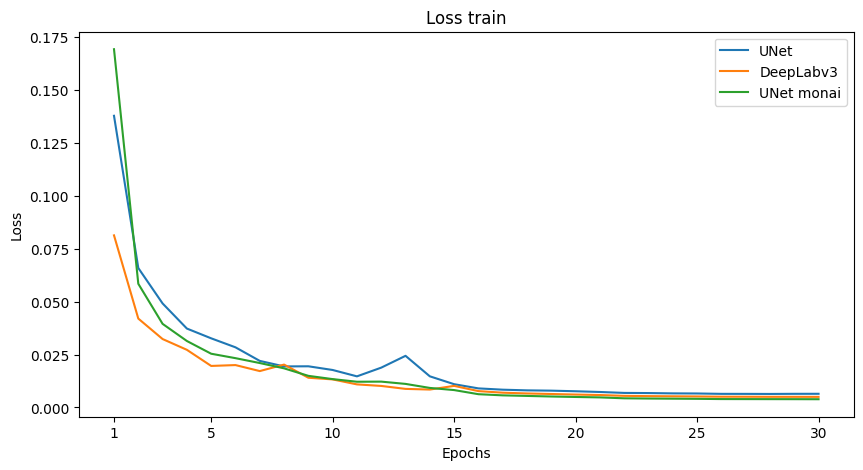

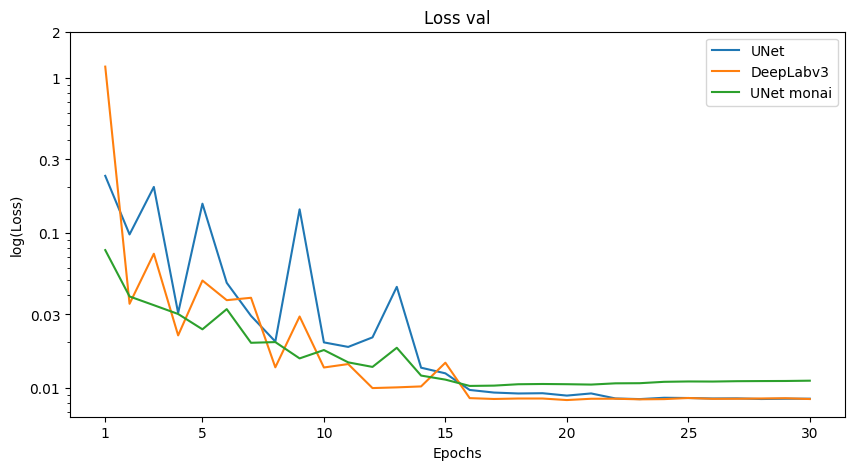

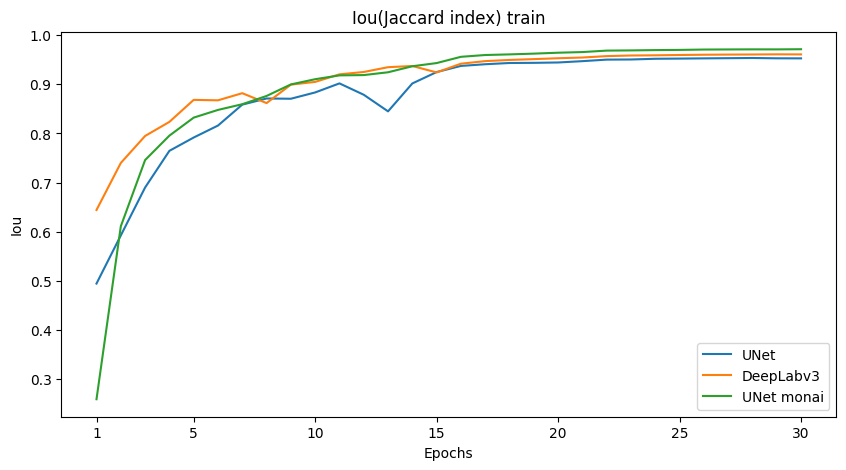

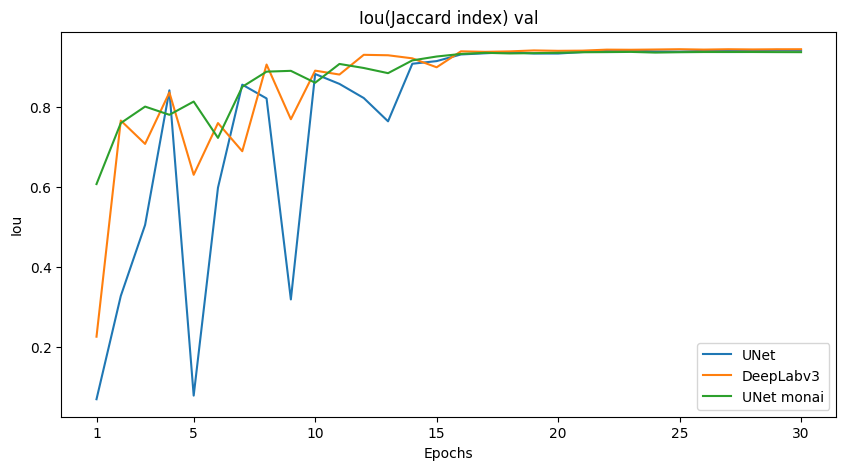

In [32]:
plt.figure(figsize=(10,5))
plt.plot(range(1,31),history_unet['epochs loss train'], label='UNet')
plt.plot(range(1,31),history_deeplabv3['epochs loss train'], label='DeepLabv3')
plt.plot(range(1,31),history_unet_monai['epochs loss train'], label='UNet monai')
plt.title('Loss train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([1] + [i for i in range(5,31,5)], [1] + [i for i in range(5,31,5)])
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(range(1,31),history_unet['epochs loss val'], label='UNet')
plt.plot(range(1,31),history_deeplabv3['epochs loss val'], label='DeepLabv3')
plt.plot(range(1,31),history_unet_monai['epochs loss val'], label='UNet monai')
plt.title('Loss val')
plt.xlabel('Epochs')
plt.ylabel('log(Loss)')
plt.xticks([1] + [i for i in range(5,31,5)], [1] + [i for i in range(5,31,5)])
plt.yscale('log')
plt.yticks([0.01,0.03,0.1,0.3,1,2],[0.01,0.03,0.1,0.3,1,2])
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(range(1,31),history_unet['iou(Jaccard index) train'], label='UNet')
plt.plot(range(1,31),history_deeplabv3['iou(Jaccard index) train'], label='DeepLabv3')
plt.plot(range(1,31),history_unet_monai['iou(Jaccard index) train'], label='UNet monai')
plt.title('Iou(Jaccard index) train')
plt.xlabel('Epochs')
plt.ylabel('Iou')
plt.xticks([1] + [i for i in range(5,31,5)], [1] + [i for i in range(5,31,5)])
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(range(1,31),history_unet['iou(Jaccard index) val'], label='UNet')
plt.plot(range(1,31),history_deeplabv3['iou(Jaccard index) val'], label='DeepLabv3')
plt.plot(range(1,31),history_unet_monai['iou(Jaccard index) val'], label='UNet monai')
plt.title('Iou(Jaccard index) val')
plt.xlabel('Epochs')
plt.ylabel('Iou')
plt.xticks([1] + [i for i in range(5,31,5)], [1] + [i for i in range(5,31,5)])
plt.legend()

In [34]:
model_unet.load_state_dict(torch.load('/kaggle/working/best_model_U-Net.pth'))
model_deeplabv3.load_state_dict(torch.load('/kaggle/working/best_model_DeepLabV3.pth'))
model_unet_monai.load_state_dict(torch.load('/kaggle/working/best_model_U-Net_monai.pth'))

<All keys matched successfully>

In [35]:
model_unet.eval()
model_deeplabv3.eval()
model_unet_monai.eval()

iou_test_unet = []
iou_test_deeplabv3 = []
iou_test_unet_monai = []

for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels
    
    with torch.no_grad():
        out_unet = model_unet(images)['out'].detach().cpu()
        out_deeplabv3 = model_deeplabv3(images)['out'].detach().cpu() 
        out_unet_monai = model_unet_monai(images).detach().cpu()
    
    iou_unet = get_iou(out_unet,labels)
    iou_deeplabv3 = get_iou(out_deeplabv3,labels)
    iou_unet_monai = get_iou(out_unet_monai,labels)
            
    iou_test_unet.append(iou_unet)
    iou_test_deeplabv3.append(iou_deeplabv3)
    iou_test_unet_monai.append(iou_unet_monai)

print('---------------------------------------------------------')
print(f'Iou(Индекс Жакара) для U-Net модели на тестовых данных: {sum(iou_test_unet)/len(iou_test_unet):.4f}')
print('---------------------------------------------------------')
print(f'Iou(Индекс Жакара) для DeeplabV3 модели на тестовых данных: {sum(iou_test_deeplabv3)/len(iou_test_deeplabv3):.4f}')
print('---------------------------------------------------------')
print(f'Iou(Индекс Жакара) для U-Net модели от Monai на тестовых данных: {sum(iou_test_unet_monai)/len(iou_test_unet_monai):.4f}')
print('---------------------------------------------------------')

---------------------------------------------------------
Iou(Индекс Жакара) для U-Net модели на тестовых данных: 0.9472
---------------------------------------------------------
Iou(Индекс Жакара) для DeeplabV3 модели на тестовых данных: 0.9463
---------------------------------------------------------
Iou(Индекс Жакара) для U-Net модели от Monai на тестовых данных: 0.9360
---------------------------------------------------------


In [36]:
model_deeplabv3.load_state_dict(torch.load('/kaggle/working/best_model_DeepLabV3.pth'))

model_deeplabv3.eval()

iou_test_deeplabv3 = []

for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels
    
    with torch.no_grad():
        out_deeplabv3 = model_deeplabv3(images)['out'].detach().cpu() 
    
    iou_deeplabv3 = get_iou(out_deeplabv3,labels)
            
    iou_test_deeplabv3.append(iou_deeplabv3)

print('---------------------------------------------------------')
print(f'Iou(Индекс Жакара) для DeeplabV3 модели на тестовых данных: {sum(iou_test_deeplabv3)/len(iou_test_deeplabv3):.4f}')
print('---------------------------------------------------------')

---------------------------------------------------------
Iou(Индекс Жакара) для DeeplabV3 модели на тестовых данных: 0.9463
---------------------------------------------------------


In [37]:
for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels
            
    with torch.no_grad():
        # out_unet = model_unet(images)['out'].detach().cpu()
        out_deeplabv3 = model_deeplabv3(images)['out'].detach().cpu()
        # out_unet_monai = model_unet_monai(images).detach().cpu()
        
    break

In [45]:
!pip install svgwrite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 657.1 kB/s eta 0:00:000:00:01


In [52]:
from svgwrite import Drawing

os.makedirs('results/jpg', exist_ok=True)
os.makedirs('results/svg', exist_ok=True)

preds = torch.sigmoid(out_deeplabv3.squeeze(0)) > 0.7
pred_masks = preds.squeeze().cpu().numpy().astype(np.uint8) * 255

images_np = images.permute(0, 2, 3, 1).cpu().numpy()
images_np = (images_np * 255).astype(np.uint8)  # Денормализация

for i, (img_np, pred_mask) in enumerate(zip(images_np, pred_masks)):
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    
    contours_pred, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    img_with_contours = img_bgr.copy()
    cv2.drawContours(img_with_contours, contours_pred, -1, (0, 255, 0), 2)  # Зеленые контуры
    
    jpg_path = f'results/jpg/result_{i}.jpg'
    cv2.imwrite(jpg_path, img_bgr)
    
    svg_path = f'results/svg/contours_{i}.svg'
    dwg = Drawing(svg_path, size=(pred_mask.shape[1], pred_mask.shape[0]))
    
    for contour in contours_pred:
        if len(contour) > 2:  # Игнорируем слишком короткие контуры
            points = [(int(pt[0][0]), int(pt[0][1])) for pt in contour]
            dwg.add(dwg.polyline(points, fill='none', stroke='green', stroke_width=2))
    
    dwg.save()
    
    # 3. Визуализация в matplotlib
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB), cmap="Blues")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Prediction with Contours")
    plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB), cmap="Blues")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'results/comparison_{i}.png', bbox_inches='tight', dpi=150)
    plt.close()

print("Обработка завершена. Результаты сохранены в папке 'results'")
print(f"- JPG с контурами: {len(pred_masks)} файлов в results/jpg/")
print(f"- SVG контуры: {len(pred_masks)} файлов в results/svg/")
print(f"- PNG сравнения: {len(pred_masks)} файлов в корневой папке")

Обработка завершена. Результаты сохранены в папке 'results'
- JPG с контурами: 8 файлов в results/jpg/
- SVG контуры: 8 файлов в results/svg/
- PNG сравнения: 8 файлов в корневой папке


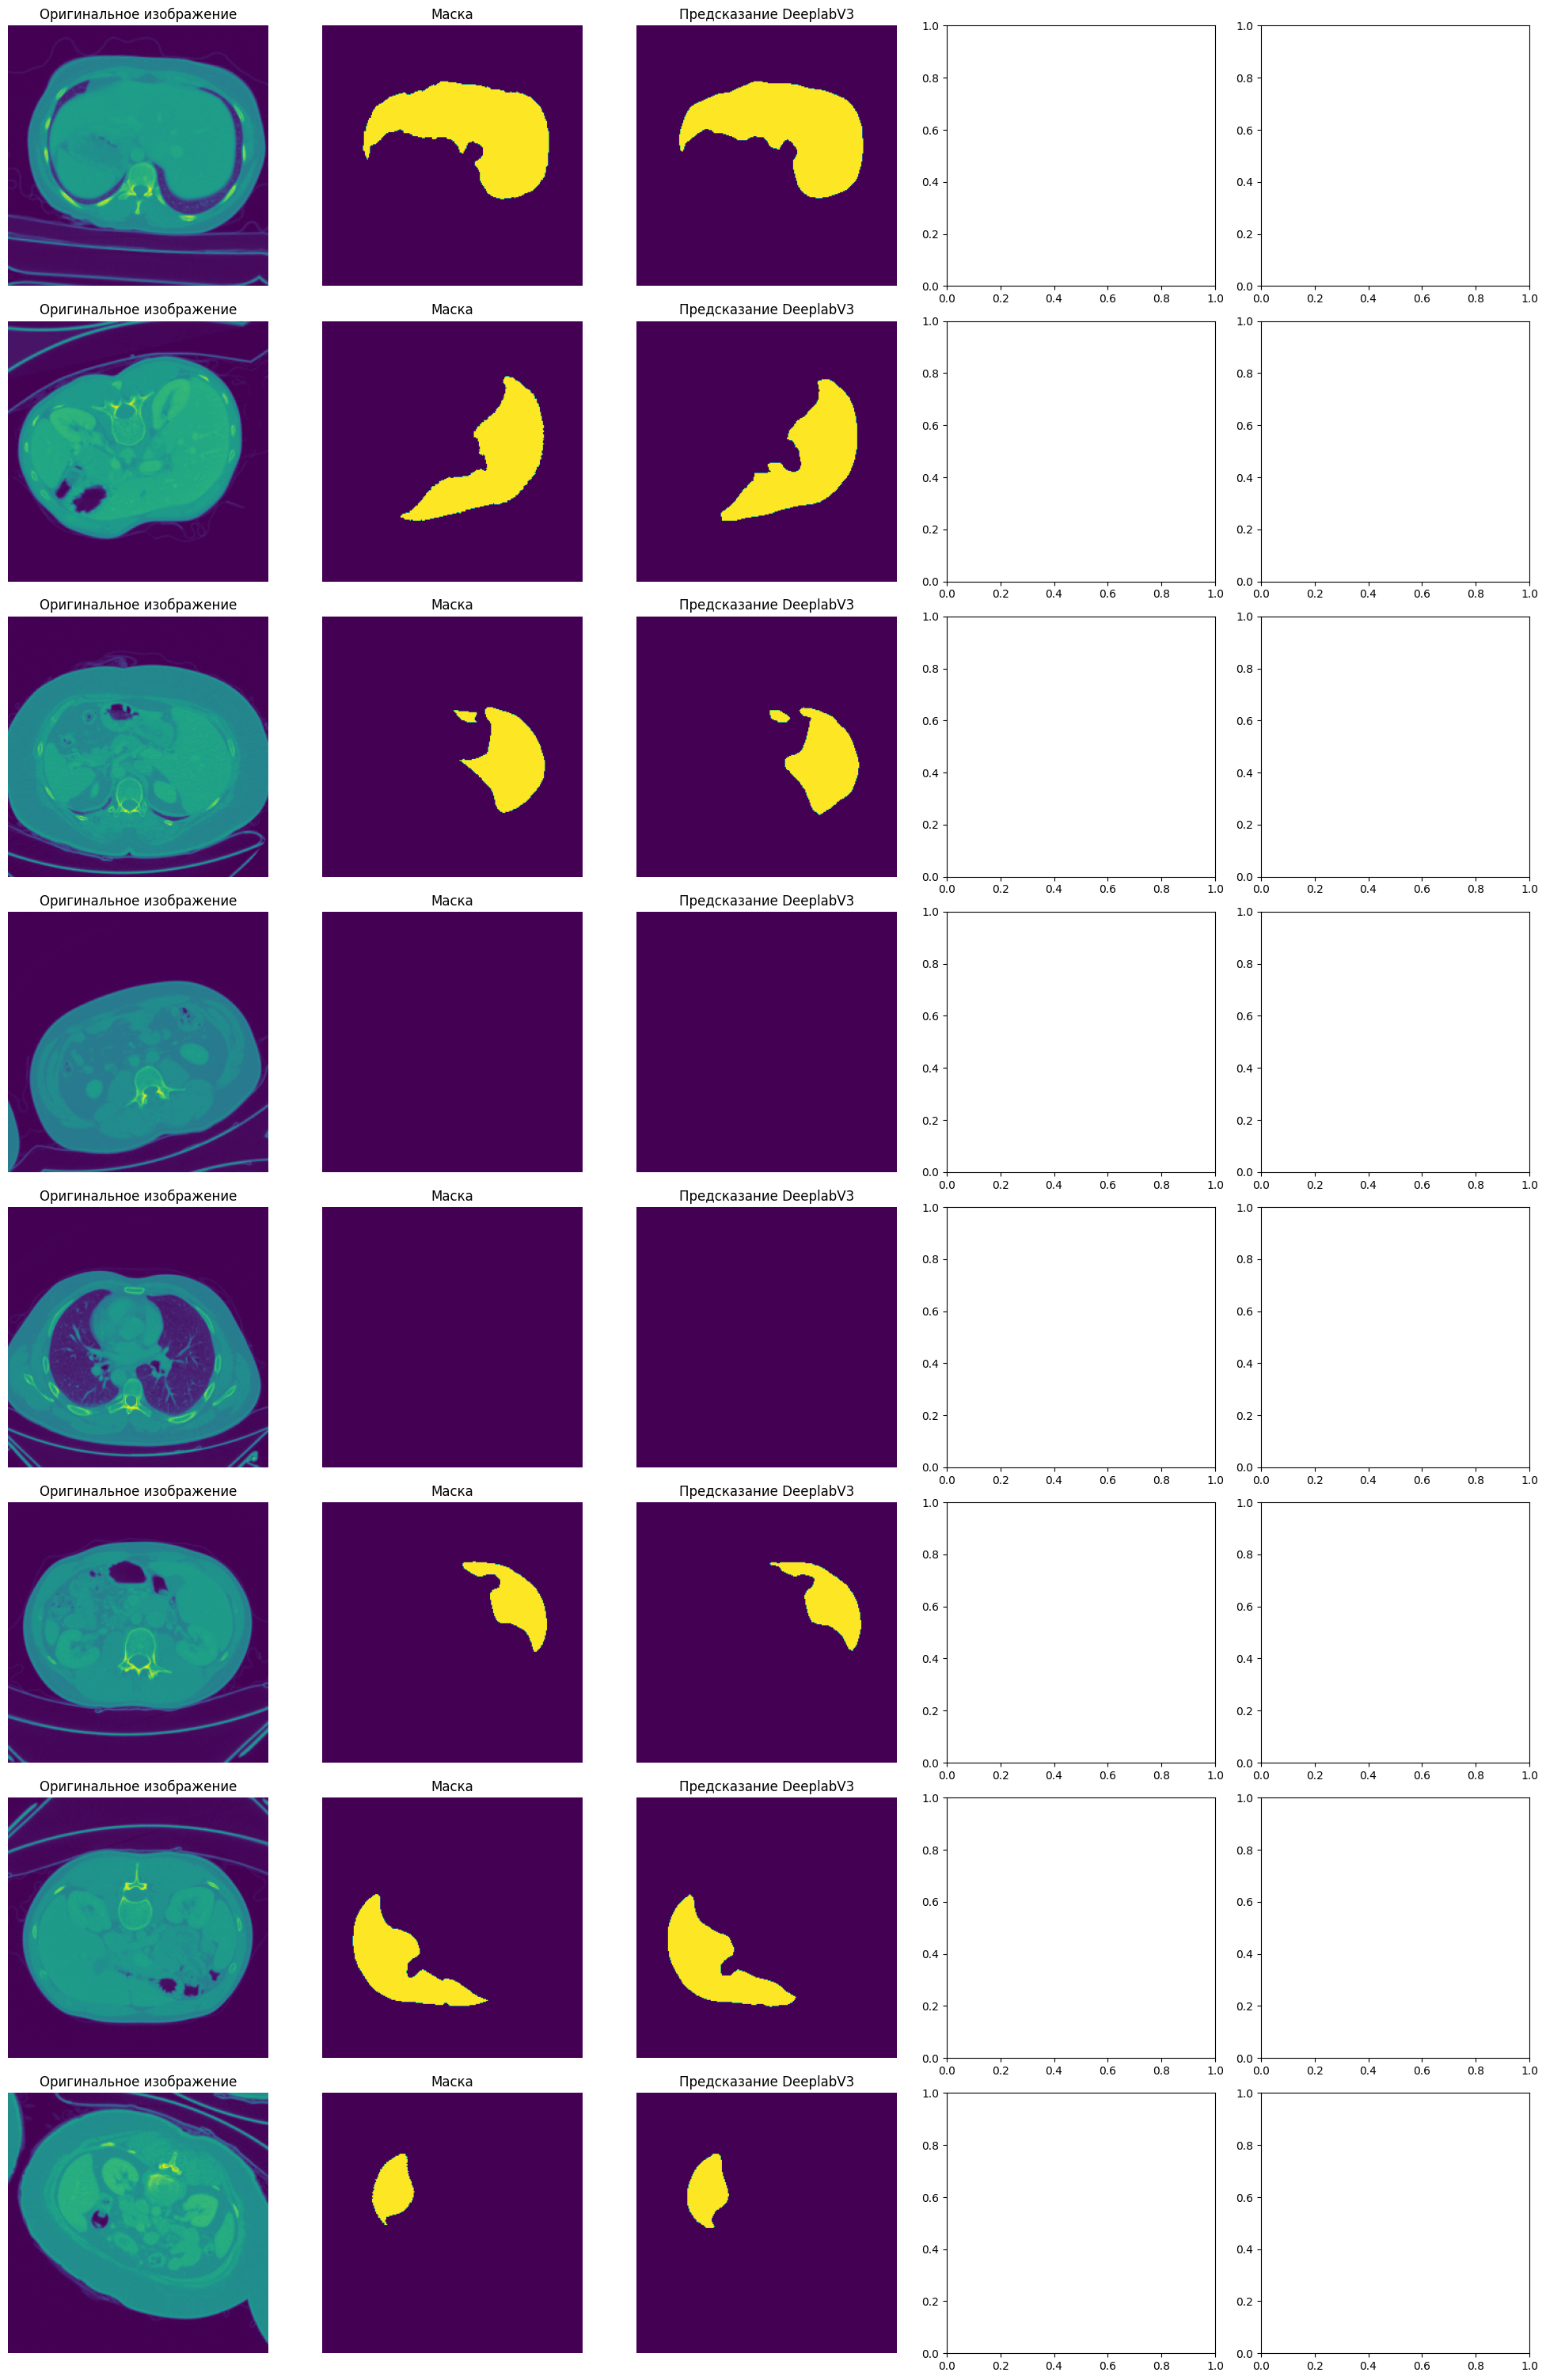

In [38]:
images = images.cpu()

fig,axes = plt.subplots(8,5,figsize=(20,30))
fig.tight_layout()
for i in range(len(axes)):
    if i<8:
        axes[i][0].imshow(images[i].squeeze(0))
        axes[i][0].set_title('Оригинальное изображение')
        axes[i][0].axis('off')

        axes[i][1].imshow(labels[i].squeeze(0))
        axes[i][1].set_title('Маска')
        axes[i][1].axis('off')

        axes[i][2].imshow(torch.sigmoid(out_deeplabv3[i].squeeze(0)) > 0.7)
        axes[i][2].set_title('Предсказание DeeplabV3')
        axes[i][2].axis('off')

        # axes[i][3].imshow(torch.sigmoid(out_unet[i].squeeze(0)) > 0.7)
        # axes[i][3].set_title('Предсказание Unet с нуля')
        # axes[i][3].axis('off')
        
        # axes[i][4].imshow(torch.sigmoid(out_unet_monai[i].squeeze(0)) > 0.7)
        # axes[i][4].set_title('Предсказание Unet monai')
        # axes[i][4].axis('off')

# **Recall,Precision,F1 score**

In [39]:
def get_recall(out,labels):
    out = torch.sigmoid(out) > 0.9
    out = out.squeeze(1)
    labels = labels.squeeze(1)
    
    tp = torch.logical_and(out,labels).sum().float()
    fn = torch.logical_and(~out, labels).sum().float()
    
    recall = tp/(tp+fn)
    
    return recall.mean().item()

def get_precision(out,labels):
    out = torch.sigmoid(out) > 0.9
    out = out.squeeze(1)
    labels = labels.squeeze(1)
    
    tp = torch.logical_and(out,labels).sum().float()
    fp = torch.logical_and(out, ~(labels.int())).sum().float()
    
    precision = tp/(tp+fp)
    
    return precision.mean().item()

def get_f1_score(out,labels):
    
    recall = get_recall(out,labels)
    precision = get_precision(out,labels)
    
    f1_score = 2*precision*recall/(precision+recall)
    
    return f1_score

In [40]:
model_unet.eval()
model_deeplabv3.eval()
model_unet_monai.eval()

recall_test_unet = []
recall_test_deeplabv3 = []
recall_test_unet_monai = []

precision_test_unet = []
precision_test_deeplabv3 = []
precision_test_unet_monai = []

f1_score_test_unet = []
f1_score_test_deeplabv3 = []
f1_score_test_unet_monai = []

for batch in test_loader:
    images, labels = batch
    images, labels = images.to(device), labels
    
    with torch.no_grad():
        out_unet = model_unet(images)['out'].detach().cpu()
        out_deeplabv3 = model_deeplabv3(images)['out'].detach().cpu() 
        out_unet_monai = model_unet_monai(images).detach().cpu()
    
    recall_unet = get_recall(out_unet,labels)
    recall_deeplabv3 = get_recall(out_deeplabv3,labels)
    recall_unet_monai = get_recall(out_unet_monai,labels)
    
    precision_unet = get_precision(out_unet,labels)
    precision_deeplabv3 = get_precision(out_deeplabv3,labels)
    precision_unet_monai = get_precision(out_unet_monai,labels)
    
    f1_score_unet = get_f1_score(out_unet,labels)
    f1_score_deeplabv3 = get_f1_score(out_deeplabv3,labels)
    f1_score_unet_monai = get_f1_score(out_unet_monai,labels)
            
    recall_test_unet.append(recall_unet)
    recall_test_deeplabv3.append(recall_deeplabv3)
    recall_test_unet_monai.append(recall_unet_monai)

    precision_test_unet.append(precision_unet)
    precision_test_deeplabv3.append(precision_deeplabv3)
    precision_test_unet_monai.append(precision_unet_monai)

    f1_score_test_unet.append(f1_score_unet)
    f1_score_test_deeplabv3.append(f1_score_deeplabv3)
    f1_score_test_unet_monai.append(f1_score_unet_monai)

print('---------------------------------------------------------')
print(f'Recall для U-Net модели на тестовых данных: {sum(recall_test_unet)/len(recall_test_unet)}')
print('---------------------------------------------------------')
print(f'Recall для DeeplabV3 модели на тестовых данных: {sum(recall_test_deeplabv3)/len(recall_test_deeplabv3):.4f}')
print('---------------------------------------------------------')
print(f'Recall для U-Net модели от Monai на тестовых данных: {sum(recall_test_unet_monai)/len(recall_test_unet_monai):.4f}')
print('---------------------------------------------------------')

print('---------------------------------------------------------')
print(f'Precision для U-Net модели на тестовых данных: {sum(precision_test_unet)/len(precision_test_unet):.4f}')
print('---------------------------------------------------------')
print(f'Precision для DeeplabV3 модели на тестовых данных: {sum(precision_test_deeplabv3)/len(precision_test_deeplabv3):.4f}')
print('---------------------------------------------------------')
print(f'Precision для U-Net модели от Monai на тестовых данных: {sum(precision_test_unet_monai)/len(precision_test_unet_monai):.4f}')
print('---------------------------------------------------------')

print('---------------------------------------------------------')
print(f'F1 score для U-Net модели на тестовых данных: {sum(f1_score_test_unet)/len(f1_score_test_unet):.4f}')
print('---------------------------------------------------------')
print(f'F1 score для DeeplabV3 модели на тестовых данных: {sum(f1_score_test_deeplabv3)/len(f1_score_test_deeplabv3):.4f}')
print('---------------------------------------------------------')
print(f'F1 score для U-Net модели от Monai на тестовых данных: {sum(f1_score_test_unet_monai)/len(f1_score_test_unet_monai):.4f}')
print('---------------------------------------------------------')

---------------------------------------------------------
Recall для U-Net модели на тестовых данных: 0.9293448101071751
---------------------------------------------------------
Recall для DeeplabV3 модели на тестовых данных: 0.9349
---------------------------------------------------------
Recall для U-Net модели от Monai на тестовых данных: 0.9273
---------------------------------------------------------
---------------------------------------------------------
Precision для U-Net модели на тестовых данных: 0.4984
---------------------------------------------------------
Precision для DeeplabV3 модели на тестовых данных: 0.4980
---------------------------------------------------------
Precision для U-Net модели от Monai на тестовых данных: 0.4977
---------------------------------------------------------
---------------------------------------------------------
F1 score для U-Net модели на тестовых данных: 0.6488
---------------------------------------------------------
F1 score для D